In [2]:
import ast
import math
from fractions import Fraction
import json
import copy
import re
import nltk
import matplotlib.pyplot as plt
from word_problem import WordProblem

In [4]:
train = WordProblem.from_file("data/train_socratic.jsonl")

misshapen number: ['2', '5'] 2:5
misshapen number: ['10', '45'] 10:45
misshapen number: ['8', '00'] 8:00
misshapen number: ['11', '00'] 11:00
misshapen number: ['13', '00'] 13:00
misshapen number: ['5', '7'] 5:7
misshapen number: ['5', '3'] 5:3
misshapen number: ['5', '30'] 5:30
misshapen number: ['6', '00'] 6:00
misshapen number: ['10', '00'] 10:00
misshapen number: ['7', '00'] 7:00
misshapen number: ['2', '1', '3'] 2:1:3
misshapen number: ['6', '11'] 6–11
misshapen number: ['10', '17'] 10:17
misshapen number: ['8', '00'] 8:00
misshapen number: ['7', '15'] 7:15
misshapen number: ['3', '00'] 3:00
misshapen number: ['3', '30'] 3:30
misshapen number: ['11', '9'] 11:9
misshapen number: ['4', '11'] 4:11
misshapen number: ['6', '00'] 6:00
misshapen number: ['9', '00'] 9:00
misshapen number: ['3', '5', '7'] 3:5:7
misshapen number: ['2', '3'] 2:3
misshapen number: ['4', '11'] 4:11
misshapen number: ['8', '3'] 8:3
misshapen number: ['4', '3', '7'] 4:3:7
misshapen number: ['2', '30'] 2:30
missh

In [189]:
nonnumeric = {}
for wp in train:
    for qt in wp.q_quantities:
        if isinstance(qt, list):
            qtc = tuple(qt)
            if qtc not in nonnumeric:
                print(qtc, "from:", wp.q_raw)
                nonnumeric[qtc] = 1
            else:
                nonnumeric[qtc] += 1
# i = 1; print(train[i].q_numeric_quantities, train[i].q_quantities)
from pprint import PrettyPrinter
pp = PrettyPrinter()
pp.pprint(sorted(nonnumeric.items(), key=lambda x: x[1], reverse=True))

('half',) from: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
('twice',) from: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
('three',) from: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?
('one',) from: Albert is wondering how much pizza he can eat in one day. He buys 2 large pizzas and 2 small pizzas. A large pizza has 16 slices and a small pizza has 8 slices. If he eats it all, how many pieces does he eat that day?
('triple',) from: Ken 

In [12]:
answer_c = [
    re.findall(r"<<([^<>]+=[^<>]+)>>", e["answer"]) # + re.findall(r"\#\#\#\#\s*(\S+)\s*", e["answer"]) 
    for e in train ]
answer_q = [
    sorted((float(n) for n in set(re.findall(r"\d+(?:\.\d+)?", e["question"]) + re.findall(r"\d+", e["answer"]))))
    for e in train]
answer_cq = [
    sorted((float(n) for c in e for n in re.findall(r"\d+(?:\.\d+)?", c))) for e in answer_c]
answer_cq_unique = [sorted(n for n in (set(cqs))) for cqs in answer_cq]

In [13]:
features_ord = sorted(zip(answer_c, answer_q, answer_cq, answer_cq_unique, train), key=lambda e: len(e[0]))
answer_c, answer_q, answer_cq, answer_cq_unique, train = (
    [t[0] for t in features_ord], 
    [t[1] for t in features_ord], 
    [t[2] for t in features_ord], 
    [t[3] for t in features_ord],
    [t[4] for t in features_ord])
keep = [set(answer_q[i]).issubset(set(answer_cq_unique[i])) for i in range(len(features_ord))]

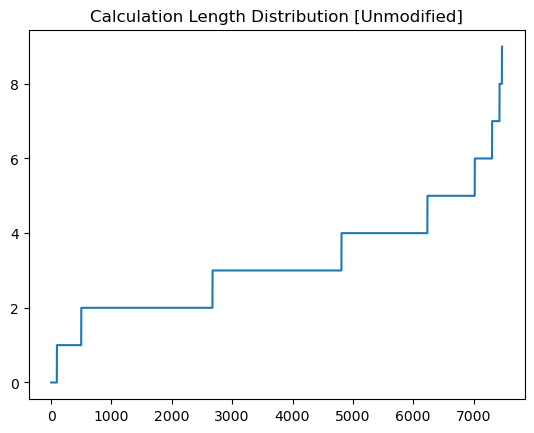

In [14]:
plt.plot(list(range(len(answer_c))), [len(c) for c in answer_c])
plt.title("Calculation Length Distribution [Unmodified]")
plt.show()

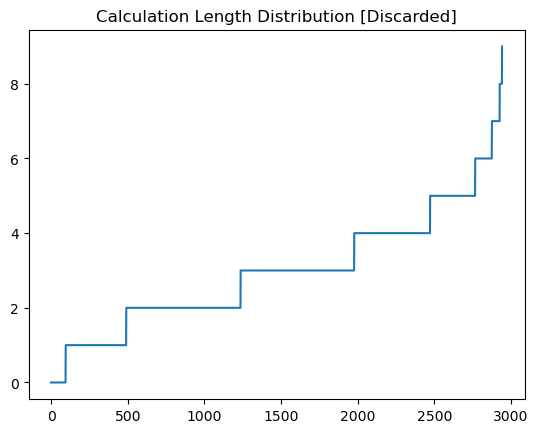

In [15]:
discarded_sizes = [len(c) for c in [c for (j, c) in enumerate(answer_c) if not keep[j]]]
plt.plot(list(range(len(discarded_sizes))), discarded_sizes)
plt.title("Calculation Length Distribution [Discarded]")
plt.show()

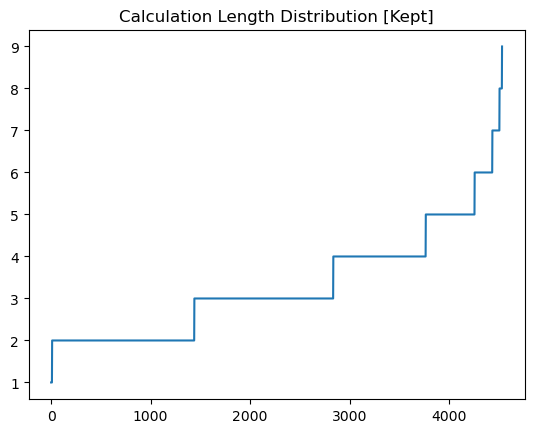

In [16]:
kept_sizes = [len(c) for c in [c for (j, c) in enumerate(answer_c) if keep[j]]]
plt.plot(list(range(len(kept_sizes))), kept_sizes)
plt.title("Calculation Length Distribution [Kept]")
plt.show()

In [17]:
answer_c, answer_q, answer_cq, answer_cq_unique, train = (
    [a for (j, a) in enumerate(answer_c) if keep[j]],
    [a for (j, a) in enumerate(answer_q) if keep[j]],
    [a for (j, a) in enumerate(answer_cq) if keep[j]],
    [a for (j, a) in enumerate(answer_cq_unique) if keep[j]],
    [a for (j, a) in enumerate(train) if keep[j]])

In [18]:
i = math.floor(2 * len(answer_c) / 3)
print(f"Q: {train[i]['question']}\n\nA: {train[i]['answer']}\n\ncalculations: {answer_c[i]}\n\nquantities: {answer_q[i]}\n\nquantities in calculations: {answer_cq[i]}")

Q: A taco truck is selling soft tacos for $2 and hard shell tacos for $5 during the lunch rush. The first group of customers is a family that buys four hard shell tacos and three soft tacos. The rest of the customers in the lunch rush only buy two soft tacos each. There were ten customers after the family. How many dollars did the taco truck make during the lunch rush?

A: The taco truck sold 3 + 2 * 10 = 3 + 20 = <<3+2*10=23>>23 soft tacos.
It made 2 * 23 = $<<2*23=46>>46 from soft tacos.
It made 5 * 4 = $<<5*4=20>>20 from hard shell tacos.
Thus, the taco truck made 46 + 20 = $<<46+20=66>>66 during the lunch rush.
#### 66

calculations: ['3+2*10=23', '2*23=46', '5*4=20', '46+20=66']

quantities: [2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 23.0, 46.0, 66.0]

quantities in calculations: [2.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 20.0, 23.0, 23.0, 46.0, 46.0, 66.0]


In [115]:
answer_calc_all = [e for c in answer_calc for e in c]
answer_calc_all_ord = sorted(answer_calc_all, key=lambda e: len(re.findall(r"\d+(?:\.\d+)?", e)))

In [116]:
answer_calc_ast = [ast.parse(c.replace(",", "").split("=")[0]) for c in answer_calc_all_ord]

In [122]:
print(answer_calc_all_ord[-3].replace(",", "").split("=")[0])
print(ast.dump(answer_calc_ast[-3], indent=4))

1/2*30+1/2*40+1/2*50
Module(
    body=[
        Expr(
            value=BinOp(
                left=BinOp(
                    left=BinOp(
                        left=BinOp(
                            left=Constant(value=1),
                            op=Div(),
                            right=Constant(value=2)),
                        op=Mult(),
                        right=Constant(value=30)),
                    op=Add(),
                    right=BinOp(
                        left=BinOp(
                            left=Constant(value=1),
                            op=Div(),
                            right=Constant(value=2)),
                        op=Mult(),
                        right=Constant(value=40))),
                op=Add(),
                right=BinOp(
                    left=BinOp(
                        left=Constant(value=1),
                        op=Div(),
                        right=Constant(value=2)),
                    op=Mult(),
               

In [128]:
answer_calc_ast[-3].body[0].value

In [101]:
answer_calc_all_ord[-10:]

['10+14+18+22+26+30=120',
 '40+50+65+36+82+72+26=371',
 '7+12+14+12+5+18+12=80',
 '40+200+300+130+40+80+444=1234',
 '.25+.5+.75+1+1.25+1.5+1.75=7',
 '1+3+5+7+9+11+13=49',
 '2+2+2+1/3+1/3+1/3=7',
 '1/2*30+1/2*40+1/2*50=60',
 '1+3+2+4+3+5+6+1+4+2=31',
 '2*100+1*50+5*20+3*10+7*5+27*1=442']

In [90]:
n_operands = [len(re.findall(r"\d+", c)) for c in answer_calc_all if "=" in c]

In [87]:
operations = [o for c in answer_calc_all for o in re.findall(r"([^\d=.,()]+)[+-]?", c)]

In [129]:
set(o for o in operations if len(o) == 1 or o[-1] not in ["-", "+"])

{'*', '+', '-', '/', '//'}

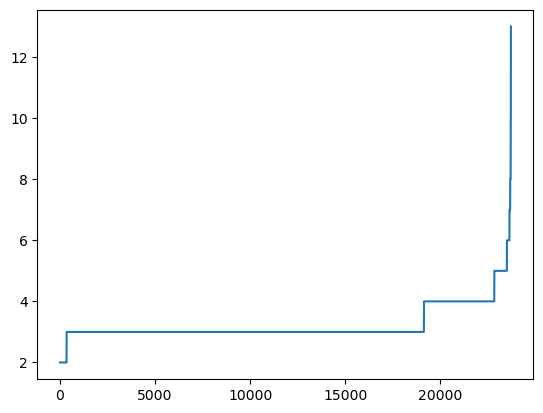

In [91]:
plt.plot(list(range(len(n_operands))), sorted(n_operands))